In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import sys

import icomo

sys.path.append("../src/")
from tapm import model_STI
from tapm import sti_infection_results_LambdaP
from tapm import utils

In [2]:
args, y0 = utils.read_params(filename="model_params_HIVandSTI.txt")

## All the equations we need to calculate Nobs and Nreal as well as their derivatives with respect to H and P

The equations I took from the Latex (double checked the implementation, but if there were mistakes in the Latex they are also here)

Derivatives Laura calculated by hand, double checked by Philipp and Antonio

In [3]:
# functions we need

@jax.jit
def Nobs(P,H):
    return lambdas(P,H)*Is(P,H) + lambdaa(P,H)*Ia(P,H)

@jax.jit
def Nreal(P,H):
    return args['beta_STI']*((1-m(P,H))*(1-P)+P) * S(P,H) * (Is(P,H)+Ia(P,H))

@jax.jit
def Is(P,H):
    return b(P,H)/a(P,H) * (1-args['psi'])/args['psi'] * Ia(P,H)

@jax.jit
def Ia(P,H):
    return ((args['mu']+args['gammaT_STI']) * (1/R0(P,H) - 1)) / (-b(P,H)/args['psi'] + args['gamma_STI'] - args['gammaT_STI']*(1 + b(P,H)/a(P,H)*(1-args['psi'])/args['psi']))

@jax.jit
def S(P,H):
    return a(P,H)/((1-args['psi'])*alpha(P,H)) * Is(P,H)/(Ia(P,H) + Is(P,H))

@jax.jit
def lambdas(P,H):
    return args['lambda_s'] + lambdaa(P,H)

@jax.jit
def lambdaa(P,H):
    return lambdaH(P,H) * (1-P) + args['lambda_P'] * P

@jax.jit
def lambdaH(P,H):
    return args['c']*(1-m(P,H))*betaHIV(P,H)*H

@jax.jit
def betaHIV(P,H):
    return args['beta_HIV'] * (1-m(P,H))

@jax.jit
def m(P,H):
    return args['min_exp'] + (args['max_exp'] - args['min_exp']) * (1 - jnp.exp(-H/args['tau_exp']))

@jax.jit
def a(P,H):
    return lambdas(P,H) + args['mu']

@jax.jit
def b(P,H):
    return args['gamma_STI'] + lambdaa(P,H) + args['mu']

@jax.jit
def R0(P,H):
    return args['psi']*alpha(P,H)/b(P,H) + (1-args['psi'])*alpha(P,H)/a(P,H)

@jax.jit
def alpha(P,H):
    return args['beta_STI'] * (1 - m(P,H)*(1 - P))


In [4]:
# derivatives of functions
# dx/dy names dx_dy for easier readability

def dNobs_dP(P,H):
    return Is(P,H)*dlambdas_dP(P,H) + Ia(P,H)*dlambdaa_dP(P,H) + lambdas(P,H)*dIs_dP(P,H) + lambdaa(P,H)*dIa_dP(P,H)

def dNobs_dH(P,H):
    return Is(P,H)*dlambdas_dH(P,H) + Ia(P,H)*dlambdaa_dH(P,H) + lambdas(P,H)*dIs_dH(P,H) + lambdaa(P,H)*dIa_dH(P,H)

def dNreal_dP(P,H):
    return args['beta_STI']*S(P,H)*(((1-m(P,H))*(1-P)+P)*(dIs_dP(P,H)+dIa_dP(P,H)) + (Is(P,H)+Ia(P,H))*m(P,H)) + Nreal(P,H)/S(P,H)*dS_dP(P,H)

def dNreal_dH(P,H):
    return args['beta_STI']*S(P,H)*(((1-m(P,H))*(1-P)+P)*(dIs_dH(P,H)+dIa_dH(P,H)) + (Is(P,H)+Ia(P,H))*((1-P)*(-dm_dH(P,H)))) + Nreal(P,H)/S(P,H)*dS_dH(P,H)

def dIs_dP(P,H):
    return 1/a(P,H)*(1-args['psi'])/args['psi']*Ia(P,H)*db_dP(P,H) + b(P,H)*(1-args['psi'])/args['psi']*Ia(P,H)*(-1/(a(P,H))**2)*da_dP(P,H) + b(P,H)/a(P,H)*(1-args['psi'])/args['psi']*dIa_dP(P,H)

def dIs_dH(P,H):
    return 1/a(P,H)*(1-args['psi'])/args['psi']*Ia(P,H)*db_dH(P,H) + b(P,H)*(1-args['psi'])/args['psi']*Ia(P,H)*(-1/(a(P,H))**2)*da_dH(P,H) + b(P,H)/a(P,H)*(1-args['psi'])/args['psi']*dIa_dH(P,H)

def dIa_dP(P,H):
    part1 = (args['mu']+args['gammaT_STI'])/(-b(P,H)/args['psi'] + args['gamma_STI'] - args['gammaT_STI']*(1+b(P,H)/a(P,H)*(1-args['psi'])/args['psi'])) * (-1/(R0(P,H))**2)*dR0_dP(P,H)
    part2 = ((args['mu']+args['gammaT_STI'])*(1/R0(P,H)-1))/(-(b(P,H)/args['psi'] + args['gamma_STI'] - args['gammaT_STI']*(1+b(P,H)/a(P,H)*(1-args['psi'])/args['psi']))**2) * (-1/args['psi']*db_dP(P,H) - args['gammaT_STI']/a(P,H)*(1-args['psi'])/args['psi']*db_dP(P,H) + args['gammaT_STI']*b(P,H)/(a(P,H))**2*(1-args['psi'])/args['psi']*da_dP(P,H))
    return part1 + part2

def dIa_dH(P,H):
    part1 = (args['mu']+args['gammaT_STI'])/(-b(P,H)/args['psi'] + args['gamma_STI'] - args['gammaT_STI']*(1+b(P,H)/a(P,H)*(1-args['psi'])/args['psi'])) * (-1/(R0(P,H))**2)*dR0_dH(P,H)
    part2 = ((args['mu']+args['gammaT_STI'])*(1/R0(P,H)-1))/(-(b(P,H)/args['psi'] + args['gamma_STI'] - args['gammaT_STI']*(1+b(P,H)/a(P,H)*(1-args['psi'])/args['psi']))**2) * (-1/args['psi']*db_dH(P,H) - args['gammaT_STI']/a(P,H)*(1-args['psi'])/args['psi']*db_dH(P,H) + args['gammaT_STI']*b(P,H)/(a(P,H))**2*(1-args['psi'])/args['psi']*da_dH(P,H))
    return part1 + part2

def dS_dP(P,H):
    part1 = 1/((1-args['psi'])*alpha(P,H)) * Is(P,H)/(Ia(P,H)+Is(P,H)) * da_dP(P,H)
    part2 = a(P,H)/((1-args['psi'])*alpha(P,H)) * 1/(Ia(P,H)+Is(P,H)) * dIs_dP(P,H)
    part3 = a(P,H)/((1-args['psi'])*alpha(P,H)) * Is(P,H) * (-1/(Ia(P,H)+Is(P,H))**2) * (dIa_dP(P,H) + dIs_dP(P,H))
    part4 = a(P,H)/(-(1-args['psi'])*(alpha(P,H))**2) * Is(P,H)/(Ia(P,H)+Is(P,H)) * dalpha_dP(P,H)
    return part1 + part2 + part3 + part4

def dS_dH(P,H):
    part1 = 1/((1-args['psi'])*alpha(P,H)) * Is(P,H)/(Ia(P,H)+Is(P,H)) * da_dH(P,H)
    part2 = a(P,H)/((1-args['psi'])*alpha(P,H)) * 1/(Ia(P,H)+Is(P,H)) * dIs_dH(P,H)
    part3 = a(P,H)/((1-args['psi'])*alpha(P,H)) * Is(P,H) * (-1/(Ia(P,H)+Is(P,H))**2) * (dIa_dH(P,H) + dIs_dH(P,H))
    part4 = a(P,H)/(-(1-args['psi'])*(alpha(P,H))**2) * Is(P,H)/(Ia(P,H)+Is(P,H)) * dalpha_dH(P,H)
    return part1 + part2 + part3 + part4

def da_dP(P,H):
    return dlambdas_dP(P,H)

def da_dH(P,H):
    return dlambdas_dH(P,H)

def db_dP(P,H):
    return dlambdaa_dP(P,H)

def db_dH(P,H):
    return dlambdaa_dH(P,H)

def dR0_dP(P,H):
    return args['psi']*alpha(P,H)*(-1/(b(P,H))**2)*db_dP(P,H) + (1-args['psi'])*alpha(P,H)*(-1/(a(P,H))**2)*da_dP(P,H) + (args['psi']/b(P,H) + (1-args['psi'])/a(P,H))*dalpha_dP(P,H)

def dR0_dH(P,H):
    return args['psi']*alpha(P,H)*(-1/(b(P,H))**2)*db_dH(P,H) + (1-args['psi'])*alpha(P,H)*(-1/(a(P,H))**2)*da_dH(P,H) + (args['psi']/b(P,H) + (1-args['psi'])/a(P,H))*dalpha_dH(P,H)

def dalpha_dP(P,H):
    return args['beta_STI']*m(P,H)

def dalpha_dH(P,H):
    return -args['beta_STI']*(1-P)*dm_dH(P,H)

def dlambdas_dP(P,H):
    return dlambdaa_dP(P,H)

def dlambdas_dH(P,H):
    return dlambdaa_dH(P,H)

def dlambdaa_dP(P,H):
    return -lambdaH(P,H) + args['lambda_P']

def dlambdaa_dH(P,H):
    return (1-P)*dlambdaH_dH(P,H)

def dlambdaH_dP(P,H):
    return 0

def dlambdaH_dH(P,H):
    return args['c']*(1-m(P,H))*betaHIV(P,H) +args['c']*(1-m(P,H))*H*dbetaHIV_dH(P,H) - args['c']*betaHIV(P,H)*H*dm_dH(P,H)

def dbetaHIV_dP(P,H):
    return 0

def dbetaHIV_dH(P,H):
    return -args['beta_HIV']*dm_dH(P,H)

def dm_dP(P,H):
    return 0

def dm_dH(P,H):
    return (args['max_exp'] - args['min_exp'])/args['tau_exp'] * np.exp(-H/args['tau_exp'])





## Compare gradient (signs) of Nobs and Nreal

In [5]:
# analytical gradient, calculated by Laura, checked by Philipp and Antonio

Ps = np.linspace(0,100,101)
Hs = np.linspace(0,20,21)

dNobs = np.zeros((len(Ps),len(Hs)))
dNreal = np.zeros((len(Ps),len(Hs)))
dNobs_signs = np.zeros((len(Ps),len(Hs)))
dNreal_signs = np.zeros((len(Ps),len(Hs)))
dNobs_dNreal_comparison = np.zeros((len(Ps),len(Hs)))

for i,P in enumerate(Ps):
    for j,H in enumerate(Hs):
        dNobs[i,j] = dNobs_dP(P,H) + dNobs_dH(P,H)
        dNreal[i,j] = dNreal_dP(P,H) + dNreal_dH(P,H)
        dNobs_signs[i,j] = np.sign(dNobs[i,j])
        dNreal_signs[i,j] = np.sign(dNreal[i,j])
        dNobs_dNreal_comparison[i,j] = np.sign(dNobs[i,j]) + np.sign(dNreal[i,j])





INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [6]:
# numerical gradient with jax.grad

dNobs_num_func = jax.grad(Nobs, argnums=(0, 1))
dNreal_num_func = jax.grad(Nreal, argnums=(0, 1))

dNobs_num = np.zeros((len(Ps),len(Hs)))
dNreal_num = np.zeros((len(Ps),len(Hs)))
dNobs_signs_num = np.zeros((len(Ps),len(Hs)))
dNreal_signs_num = np.zeros((len(Ps),len(Hs)))
dNobs_dNreal_comparison_num = np.zeros((len(Ps),len(Hs)))

for i,P in enumerate(Ps):
    for j,H in enumerate(Hs):
        dPobs,dHobs = dNobs_num_func(P,H)
        dNobs_num[i,j] = dPobs + dHobs
        dPreal,dHreal = dNreal_num_func(P,H)
        dNreal_num[i,j] = dPreal + dHreal
        dNobs_signs_num[i,j] = np.sign(dNobs_num[i,j])
        dNreal_signs_num[i,j] = np.sign(dNreal_num[i,j])
        dNobs_dNreal_comparison_num[i,j] = np.sign(dNobs_num[i,j]) + np.sign(dNreal_num[i,j])


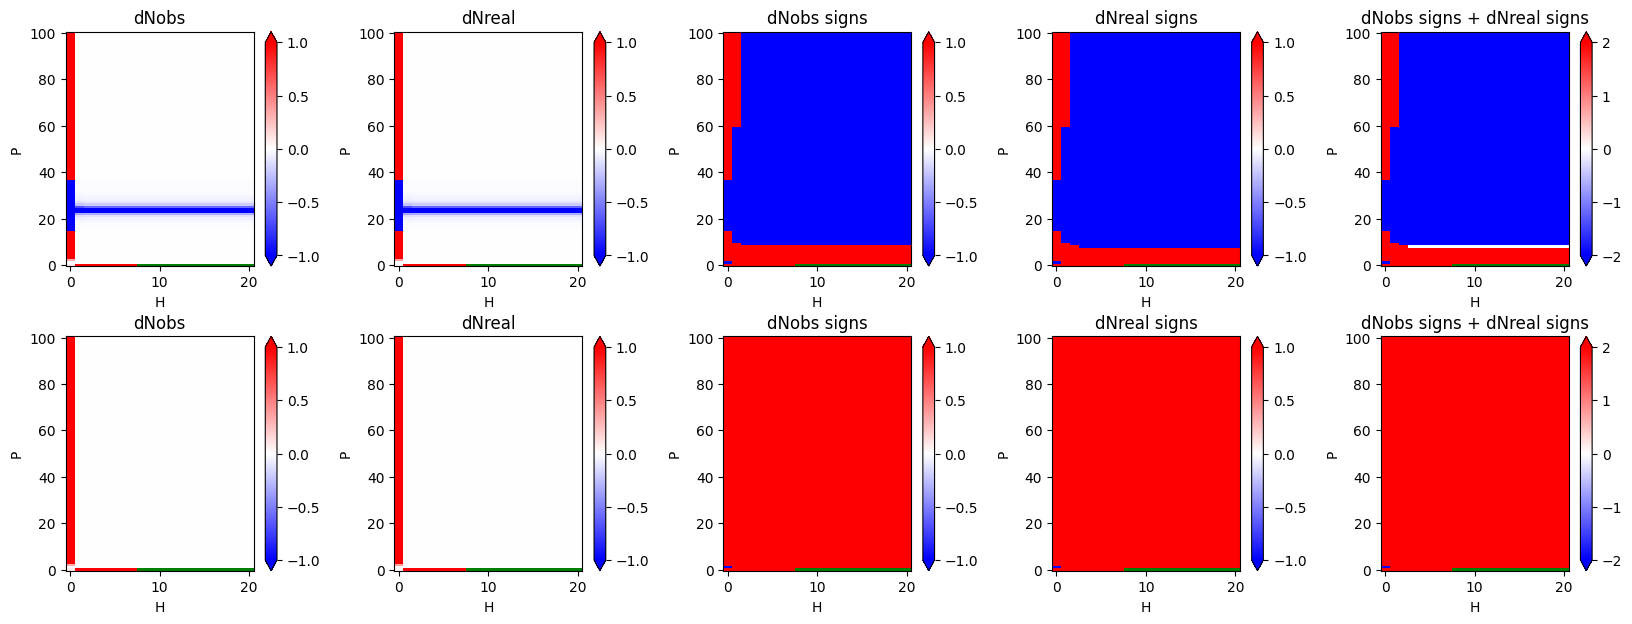

In [18]:
# plotting

plots_ana = [dNobs, dNreal, dNobs_signs, dNreal_signs, dNobs_dNreal_comparison] # analytical solutions
plots_num = [dNobs_num, dNreal_num, dNobs_signs_num, dNreal_signs_num, dNobs_dNreal_comparison_num] # numerical solutions
titles = ["dNobs", "dNreal", "dNobs signs", "dNreal signs", "dNobs signs + dNreal signs"]

fig, axs = plt.subplots(2,5,figsize=(20,7))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
cmaps = ['bwr', 'bwr', 'bwr', 'bwr', 'bwr']
clims = [(-1,1), (-1,1), (-1,1), (-1,1), (-2,2)]

for j,plots in enumerate([plots_ana, plots_num]): # first row analytical, second row numerical
    for i,col in enumerate(cmaps):
        ax = axs[j,i]
        cmap = plt.get_cmap(col)
        cmap.set_bad(color = 'green', alpha = 1.) # set color for NaN values
        ax.set_xlabel("H")
        ax.set_ylabel("P")
        pcm = ax.pcolormesh(Hs, Ps, plots[i],cmap=cmap) # plot the data
        pcm.set_clim(clims[i])
        fig.colorbar(pcm, ax=axs[j,i], shrink=1,extend='both')
        ax.set_title(titles[i])


plt.show()

## Compare Nobs and Nreal (not derivatives)

In [19]:

Nobs_vals = np.zeros((len(Ps),len(Hs)))
Nreal_vals = np.zeros((len(Ps),len(Hs)))
Nobs_Nreal_vals_comparison = np.zeros((len(Ps),len(Hs)))

for i,P in enumerate(Ps):
    for j,H in enumerate(Hs):
        Nobs_vals[i,j] = Nobs(P,H)
        Nreal_vals[i,j] = Nreal(P,H)
        Nobs_Nreal_vals_comparison[i,j] = Nobs_vals[i,j] - Nreal_vals[i,j]



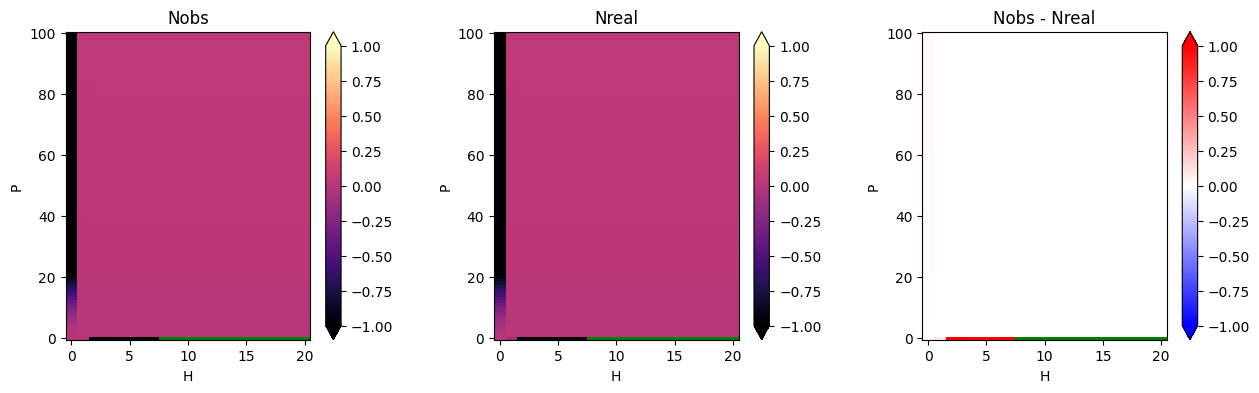

In [22]:
# plotting

plots = [Nobs_vals, Nreal_vals, Nobs_Nreal_vals_comparison] 
titles = ["Nobs", "Nreal", "Nobs - Nreal"]

fig, axs = plt.subplots(1,3,figsize=(15,4))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
cmaps = ['magma', 'magma', 'bwr']

for i,col in enumerate(cmaps):
    ax = axs[i]
    cmap = plt.get_cmap(col)
    cmap.set_bad(color = 'green', alpha = 1.) # set color for NaN values
    ax.set_xlabel("H")
    ax.set_ylabel("P")
    pcm = ax.pcolormesh(Hs, Ps, plots[i],cmap=cmap) # plot the data
    pcm.set_clim((-1,1))
    fig.colorbar(pcm, ax=axs[i], shrink=1, extend='both')
    ax.set_title(titles[i])

plt.show()